In [0]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# feature extract을 위해서는 vgg19를 쓸 예정이라고 함
  

In [0]:
vgg = models.vgg19(pretrained=True).features


for param in vgg.parameters():
  param.requires_grad_(False)

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)
# features만 가져왔기 때문에 classifier 값은 없다.
# conv2d의 첫 번째 layer는 3. RGB 때문.

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
# content image, style image 두 개가 필요함

def load_image(image_path, max_size=400, shape=None): # 이미지 사이즈를 줄여 학습속도를 빠르게 하기 위함. 정사각형 400으로 제한
  image = Image.open(image_path).convert("RGB")
  # import한 이미지를 standard한 RGB값으로 변경해 주는 듯

  # 이제 이 이미지를 vgg19 모델에 적용할 수 있도록 변경해 주면 된다
  # max size 조절
  if max(image.size) > max_size:
    # 가로든 세로든 상관없다. 가장 큰 값
    size = max_size
  else:
    size = max(image.size)
    
    
  # shape를 써서, style image가 반드시 content image의 shape와 동일하도록 변경해준다
  if shape is not None:
    size = shape
  
  in_transform = transforms.Compose([
      transforms.Resize(size),
      # resize command는 maintains the aspect ratio of relative size of horizontal / vertical value.
      transforms.ToTensor(),
      transforms.Normalize((.5,.5,.5),(.5,.5,.5))
  ])
  
  image = in_transform(image).unsqueeze(0) # 맨 앞에 dim 추가
  return image

In [0]:
# image.zip 파일의 city를 content image로,
# starrynight를 style image로 활용할 예정
content = load_image("City.jpg").to(device)
style = load_image("StarryNight.jpg", shape = content.shape[-2:]).to(device)
#[-2:]의 의미는 맨 뒤 두 개 element인데, 두 개가 height weight를 의미함.

In [0]:
# 로딩여부 확인용 plotting
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  # print(image.shape) 해보면 (1,3,400,600) 나온다.
  # 이게 문제이기에 squeeze() 해주는 듯
  image = image.squeeze()
  #print(image.shape)
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

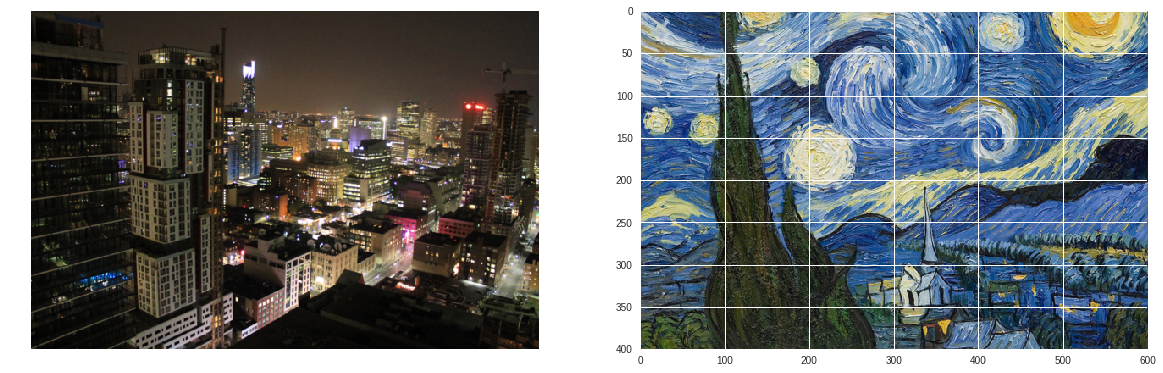

In [88]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10)) #single row 2 col
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))

# 여기서 강사는 사파리 브라우저 써서 오류났다고 함. 크롬 쓰길

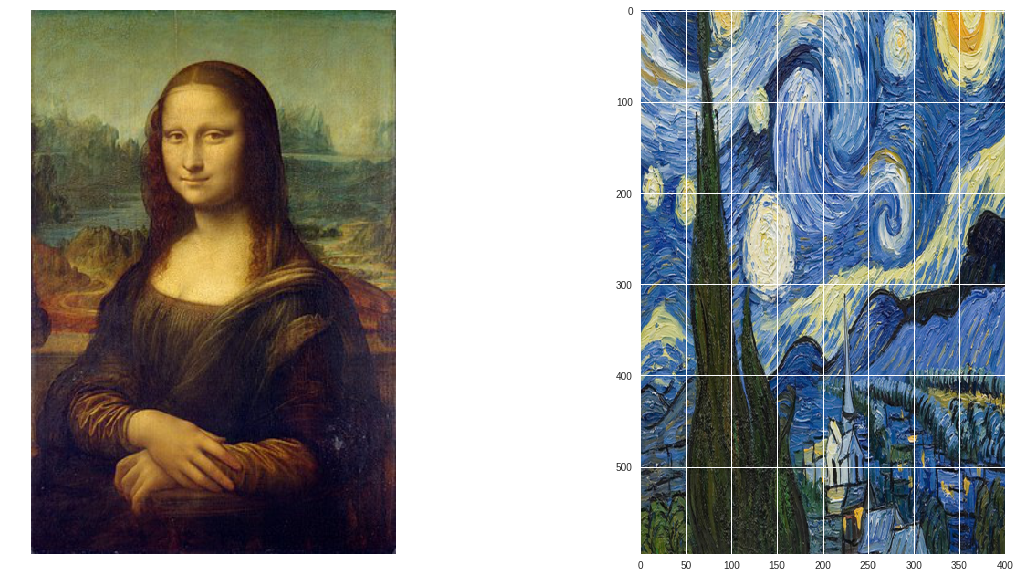

In [67]:
# more effective style transfer를 위해 몇 가지 수정을 가할 것
# 1. 학습 대상인 content와 style 이미지 크기가 같아야 효율이 좋다
# city와 starrynight는 운좋게도 동일한 사이즈. 이게 아닐 수 있는 경우가 모나리자

# style 이미지가 반드시 content 이미지 size를 따르도록 변경할 예정

content2 = load_image('MonaLisa.jpg').to(device)
style = load_image("StarryNight.jpg", shape = content2.shape[-2:]).to(device)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10)) #single row 2 col
ax1.imshow(im_convert(content2))
ax1.axis('off')
ax2.imshow(im_convert(style))


In [0]:
# separate style of image from content / 
# transfer style element -> into content img
# by feature extraction. 

# 프로세스는 3개의 이미지가 필요함. style img, content img, target img

# 1. selecting a few layers within model to extract features from.
#  = extracting the output of model prematurely at a few dif locations in model
# 이 과정을 통해 'how our image is being processed throughout N.network'
# style image와 content image에서 model features를 extract한다.

# 2. extract features from our target image 
# and compare it to our style img features and content img feature.

# 다시말해 content features of target img -> match the feature of content img.

# 2:40 부근인데 뭐라는거지



In [0]:
# feature 얻는 함수
# input image / feature 가져올 모델
def get_features(image, model):
  # 모델 아키텍처에서 필요한 레이어를 가져온다.
  # max pool 기준으로 conv 세트가 5개로 나뉘는데,
  # 각 conv 세트에서 첫 번째 layer를 불러온다. 단 4번째 세트에서는 1째, 2째 레이어 둘 다 불러옴
  # 0, 5, 10, 19, 21, 28
  
  # 이 6개의 레이어 중에서 5개는 style extraction에, 1개는 content extraction에 사용할 예정
  layers = {'0' : 'conv1_1',
             '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2', # 여기가 content extraction
            '28': 'conv5_1'
           }
  # content extraction에는 하나의 레이어만 써도 충분하다고 함.
  # this layer is also deeper into our N.network, 
  # and will provide high depth img feature
  # 이 이유는, pretrained model의 object detection conv on N.net이 very effective
  # at representing content element.
  
  # matching content features with target img features 
  # will allow for optimal content creation in target image
  
  # 5개의 layer에서 각각 style of features extract.
  # 더 많은 레이어를 가져오면 더 style image에 근접해지겠지..? 7:34 부분
  
  features = {}
  
  for name, layer in model._modules.items():
    # return all layers in our model, layer variable은 layer info를 가지고 있을 것
    # dictionary 값으로 layer 이름 정하기 위해 name 변수 사용
    image = layer(image) # 특정 layer에서 나온 output을 다시 Input으로 넣는 것
    if name in layers:
      features[layers[name]] = image
  
  return features

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [0]:
# gram matrix 사용하기. effective style feature extraction을 위해 필요함
# style에서 뽑아낸 feature에 content 내용이 많이 들어있기 때문에. (object structure, positioning..)
# content 정보는 지우고 style 정보만 남기도록 만드는 게 gram matrix라고 함

# gram matrix를 쓰면 create texture info related to data
# gram = V.transpose.dot(V)

In [0]:
def gram_matrix(tensor):
  # 그림을 input으로 받으면, dim은 4개가 존재한다.
  # begin, by unwrapping tensor dim into their respective variable
  # batch size b, image dept d, image height h, image width w
  # 여기서 batch size는 안 쓰기 때문에 지워도 된다
  _, d, h, w = tensor.size()
  # 2 dim tensor로 만들어 줘야 함
  tensor = tensor.view(d, h*w)
  # depth는 유지하고, each input channel을 곱해서 구한 결과값 갖고 2차원 dim을 만든다.
  
  # gram matrix 변수를 만든다. torch의 matmul 함수 사용
  gram = torch.mm(tensor, tensor.t())
  return gram

In [0]:
style_grams = {layer : gram_matrix(style_features[layer])
              for layer in style_features}
# specific layers가 key값, value가 gram matrix 값이 될 것

# style feature로 5개를 선정했었다.
# this provides a variety of avenues for reconstruction of image style
# which also leaves room for customised ability.

# 따라서 prioritize certain layers over other layers
# by associating certain weight parameters.
# 모델의 앞부분에 있는 layer일수록 recreating style features에 강점,
# 뒷부분의 layer일수록 additional variety towards the style elements
# customized arrangement가 가능한 부분.
# 우리의 경우 early layer에 weight heavily하는 게 ideal



In [0]:
style_weights = {
    'conv1_1':1,
    'conv2_1':.75,
    'conv3_1':.2,
    'conv4_1':.2,
    'conv5_1':.2
}

# 또 결정할 게, amount of balance we dictated btwn content / style image.
# this allows us to customize final target image 
# by defining the ratio of style to content
# 논문에서는 알파, 베타값임. 알파는 content image weight, 베타는 style image weight
# 예시에서는 10^-4 값이 적절한 정도였음. 하지만 이 강의에서는 더 낮은 비율을 사용한다고
content_weight = 1
style_weight = 1e6 # -6승



In [0]:
# target image 설정. 논문에서는 random white noise img를 사용한 다음 최적화 진행하라고 함.
# 강의에서는 target으로 원본이미지로 설정하고, weight 변화에 따라
# 얼마나 transfer가 진행되는지 확인할 예정

target = content.clone().requires_grad_(True).to(device)
# target 이미지가 optimization process에 따라 바뀌어야 하기 때문에 require grad는 true
# 이게 이미지 initialization

In [0]:
# train process 시각화하기
show_every = 300

# optimize 대상인 이미지를 optimizer에 넣는다
optimizer = optim.Adam([target], lr = .003)

# lower the loss value = more efficient style transfer임.
# 2100 step을 최소값으로 산정할 예정. iteration 수치를 늘리면 다른 결과를 얻을 수 있다.
steps = 2100

height, width, channel = im_convert(target).shape

# data visualization용. target 이미지를 process마다 저장 -> 끝나고 visualize
image_array = np.empty(shape=(300,height, width, channel)) # it will resembles the shape of target image.
# 300을 설정한 이유는 이미지 frame을 최대 300개만 저장하기 위해서. 

capture_frame = steps / 300

# array index to make sure that the frame 
counter = 0

Total loss:  2887492.75
Iteration:  300


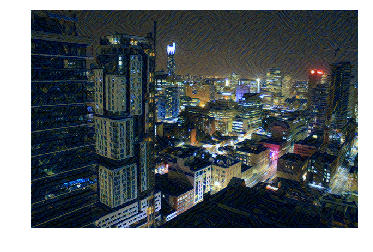

Total loss:  949766.6875
Iteration:  600


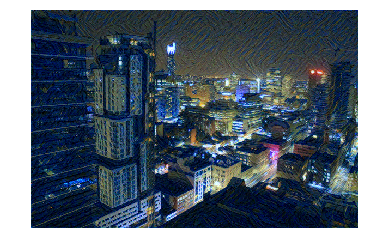

Total loss:  658488.125
Iteration:  900


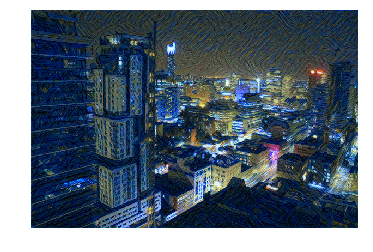

Total loss:  510494.9375
Iteration:  1200


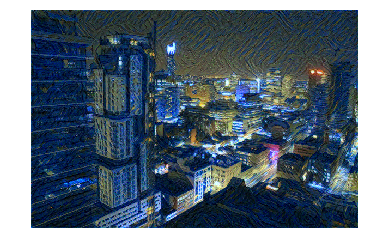

Total loss:  400814.3125
Iteration:  1500


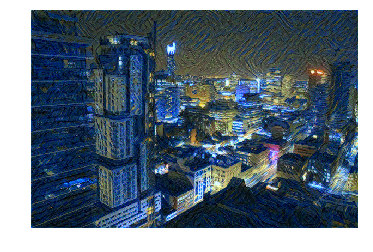

Total loss:  315035.4375
Iteration:  1800


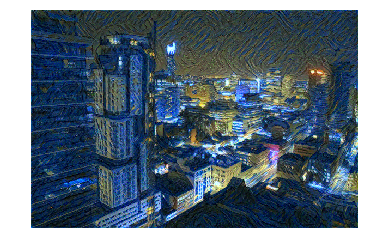

Total loss:  246968.796875
Iteration:  2100


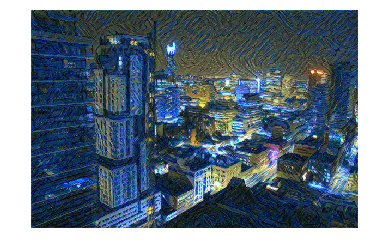

In [100]:
for ii in range(1, steps+1):
  
  # target image의 현재 feature를 저장한다
  target_features = get_features(target, vgg)
  
  # content loss는 mse를 이용했다.
  # content feature는 target image와 최대한 비슷하게 맞춰야 한다. 따라서 이 loss는 최소화해야 함
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  
  # style loss는 5개의 different layers 값을 계산해야 함.
  style_loss = 0
  
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    
    style_gram = style_grams[layer]
    # style loss에는 위에서 설정한 가중치가 필요하다. 그 가중치를 곱해준 것. loss는 마찬가지로 mse
    layer_style_loss = style_weights[layer]* torch.mean((target_gram - style_gram)**2)
    
    # target feature의 depths, heights, widths. 이 값들은 normalized를 위해 사용한다고 함.
    _, d, h, w = target_feature.shape
    
    # loss needs to be normalized. to obtain the unit loss (gram matrix를 entire layer에 적용하기 때문이라고)
    # 여기서 왜 normalize??
    style_loss += layer_style_loss / (h*w*d)
    
    
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
    
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1
    
   

In [0]:
import cv2 

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()

In [0]:
from google.colab import files
files.download('output.mp4')